# Fraud Detection

In [1]:
import ast
  

import category_encoders as ce

from flask import Flask, jsonify, request
import json
import joblib

import pandas as pd

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn import model_selection
from sklearn.ensemble import IsolationForest
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, make_scorer, recall_score
from sklearn.model_selection import train_test_split


from tqdm import tqdm

import torch
import torch.nn as nn
from torch.autograd import Variable as V
import torch.nn.functional as F
from torch.utils.data import DataLoader

#### Load dataset

In [5]:
data = pd.read_csv('../dataset/transactions_train.csv')

In [6]:
data.head()

,step,type,amount,nameOrig,oldbalanceOrig,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0


In [7]:
data_fraud = data[data['isFraud']==1]
data_non_fraud = data[data['isFraud']==0]

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6351193 entries, 0 to 6351192
Data columns (total 10 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrig  float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
dtypes: float64(5), int64(2), object(3)
memory usage: 484.6+ MB


In [25]:
def plot_pie(column: str)-> None:

    """
    This function displays a count plot for a paticular column in 
    the entire dataset

    Args:
        column: column to plot

    Return:
        None
    """
    _, ax = plt.subplots(figsize = (11, 6))
    data[column].value_counts(normalize=True).plot(kind='pie')
    plt.title(f'Plot of count of {column}')
    plt.legend()
    plt.plot()

In [12]:
def plot_counts(column: str)-> None:

    """
    This function displays a count plot for a paticular column in 
    the entire dataset

    Args:
        column: column to plot

    Return:
        None
    """
    _, ax = plt.subplots(figsize = (11, 6))
    data[column].value_counts(normalize=True).plot(kind='bar', axes = ax)
    plt.title(f'Plot of count of {column}')
    plt.xlabel('Elements in the column')
    plt.ylabel('count')
    plt.plot()


def plot_counts_non_fraud(column: str)-> None:

    """
    This function displays a count plot for a paticular column in 
    the none fraudulent dataset

    Args:
        column: column to plot

    Return:
        None
    """
    _, ax = plt.subplots(figsize = (11, 6))
    data_non_fraud[column].value_counts(normalize=True).plot(kind='bar', axes = ax)
    plt.title(f'Plot of count of {column} in non-fraud dataset')
    plt.xlabel('Elements in the column')
    plt.ylabel('count')
    plt.plot()

def plot_counts_fraud(column: str)-> None:

    """
    This function displays a count plot for a paticular column in 
    the fraudulent dataset

    Args:
        column: column to plot

    Return:
        None
    """
    _, ax = plt.subplots(figsize = (11, 6))
    data_fraud[column].value_counts(normalize=True).plot(kind='bar', axes = ax)
    plt.title(f'Plot of count of {column} in Fraud dataset')
    plt.xlabel('Elements in the column')
    plt.ylabel('count')
    plt.plot()

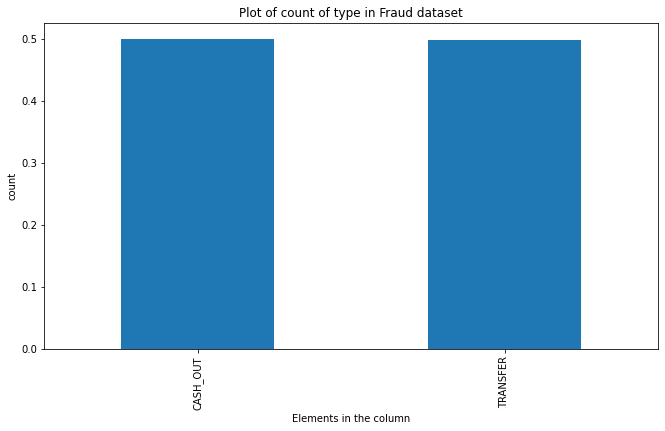

In [13]:
plot_counts_fraud('type')

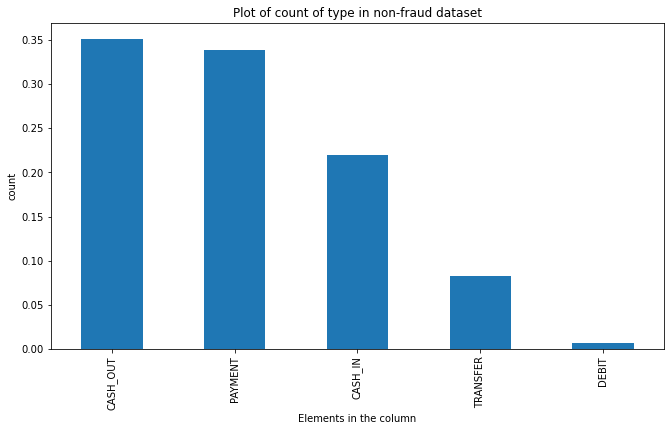

In [14]:
plot_counts_non_fraud('type')

In [9]:
data_fraud['step'].value_counts()

212    40
523    30
249    28
387    28
501    28
       ..
589     2
662     2
202     2
23      2
252     2
Name: step, Length: 697, dtype: int64

In [10]:
data_non_fraud['step'].value_counts()

19     51341
18     49563
187    49073
235    47481
307    46952
       ...  
27        33
454       33
529       27
613       25
675       20
Name: step, Length: 413, dtype: int64

In [11]:
data_fraud['nameOrig'].value_counts()

C1305486145    1
C1158527799    1
C915102234     1
C9486206       1
C777622163     1
              ..
C369516790     1
C1926697362    1
C1370685766    1
C174356762     1
C1491503658    1
Name: nameOrig, Length: 7717, dtype: int64

In [12]:
data_non_fraud['nameOrig'].value_counts()

C2051359467    3
C1784010646    3
C1832548028    3
C1999539787    3
C724452879     3
              ..
C1642468927    1
C1612159858    1
C1738029554    1
C1863188703    1
C700991352     1
Name: nameOrig, Length: 6334217, dtype: int64

In [13]:
data_fraud['nameDest'].value_counts()

C385133759     2
C1013511446    2
C475338087     2
C2020337583    2
C1827219533    2
              ..
C1734777637    1
C1965664830    1
C894811944     1
C685365077     1
C454424230     1
Name: nameDest, Length: 7677, dtype: int64

In [14]:
data_non_fraud['nameDest'].value_counts()

C1286084959    113
C985934102     109
C665576141     105
C2083562754    102
C1590550415    101
              ... 
M1365071430      1
M475293185       1
M1250406584      1
M1818997297      1
M358479392       1
Name: nameDest, Length: 2714423, dtype: int64

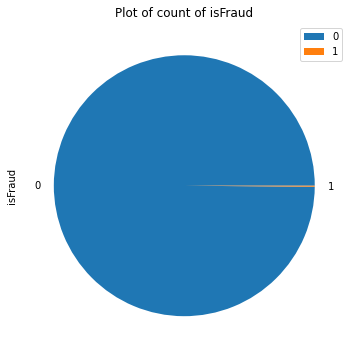

In [26]:
plot_pie('isFraud')

In [16]:
print(f'size of data: {len(data)}')
print(f'size of fraud data: {len(data_fraud)}')
print(f'size of non-fraud data: {len(data_non_fraud)}')

size of data: 6351193
size of fraud data: 7717
size of non-fraud data: 6343476


### Preping dataset for modelling

In [17]:
final_data = data[(data['type']=='CASH_OUT') | (data['type'] =='TRANSFER')].reset_index(drop = True)

columns=final_data.drop(columns = ['isFraud']).columns

# Encoding categorical variables
encoder = ce.TargetEncoder(cols=['type', 'nameOrig', 'nameDest'])
X = final_data.drop(columns =['isFraud'])
y = final_data[['isFraud']]
encoder.fit(X, y)
X_cleaned = encoder.transform(X)



In [18]:
joblib.dump(encoder, 'target_encoding.gz')

['target_encoding.gz']

In [19]:
final_data = X_cleaned
final_data['isFraud'] = y
final_data.head()

,step,type,amount,nameOrig,oldbalanceOrig,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud
0,1,0.007237,181.00,0.002791,181.0,0.0,3.703704e-02,0.0,0.00,1
1,1,0.001732,181.00,0.002791,181.0,0.0,3.225806e-02,21182.0,0.00,1
2,1,0.001732,229133.94,0.002791,15325.0,0.0,5.245554e-15,5083.0,51513.44,0
3,1,0.007237,215310.30,0.002791,705.0,0.0,2.608834e-16,22425.0,0.00,0
4,1,0.007237,311685.89,0.002791,10835.0,0.0,1.960784e-02,6267.0,2719172.89,0


In [20]:
final_fraud = final_data[final_data['isFraud']==1]
final_non_fraud = final_data[final_data['isFraud']==0]

X_train_non, X_test_non, y_train_non, y_test_non = train_test_split(final_non_fraud.drop(columns =['isFraud']), final_non_fraud[['isFraud']],test_size=0.1, random_state=42)

X_train_non, X_val_non, y_train_non, y_val_non = train_test_split(X_train_non, y_train_non, test_size=(len(y_test_non)/len(y_train_non)), random_state=42)

X_val_fraud, X_test_fraud, y_val_fraud, y_test_fraud = train_test_split(final_fraud.drop(columns =['isFraud']), final_fraud[['isFraud']],test_size=0.5, random_state=42)

In [21]:
X_train = X_train_non
y_train = y_train_non
X_val = pd.concat([X_val_non, X_val_fraud], ignore_index=True)
y_val = pd.concat([y_val_non, y_val_fraud], ignore_index=True)
X_test = pd.concat([X_test_non, X_test_fraud], ignore_index=True)
y_test = pd.concat([y_test_non, y_test_fraud], ignore_index=True)

# Scaling all features
X_train_train, X_train_val, y_train_train, y_train_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

scaler = MinMaxScaler()
scaler.fit(X_train_train)


X_train_train = pd.DataFrame(scaler.transform(X_train_train), columns = columns)
X_train_val = pd.DataFrame(scaler.transform(X_train_val), columns = columns)
X_train = pd.DataFrame(scaler.transform(X_train), columns = columns)
X_val = pd.DataFrame(scaler.transform(X_val), columns = columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns = columns)



In [22]:
joblib.dump(scaler, 'min_max_scaler.gz')

['min_max_scaler.gz']

### Base-line Models

In [23]:
def plot_confusion_matrix(confusion_matrix: np.ndarray, model_type: str)-> None:

    """
    This function plots a confusion matrix for model prediction

    Args:
        confusion_matrix: np array having the confusion matrix
        model_type: model used to generate predictions

    Output:
        None
    """

    _, ax = plt.subplots(figsize = (11, 6))

    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ['{0:0.0f}'.format(value) for value in
                    confusion_matrix.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in
                        confusion_matrix.flatten()/np.sum(confusion_matrix)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
            zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(confusion_matrix, annot=labels, fmt='', ax=ax, 
                    cmap='Blues', yticklabels= ['predicted_none_fraud', 'predicted_fraud'],
                    xticklabels=['truely_none_fraud', 'truely_fraud'])
    plt.title(f'Confusion matrix for {model_type}')
    plt.plot()

In [24]:
Xtr =  pd.concat([X_train, X_val], ignore_index=True)
ytr = pd.concat([y_train, y_val], ignore_index=True)

##### Logistic Regression

0.21223114796579426

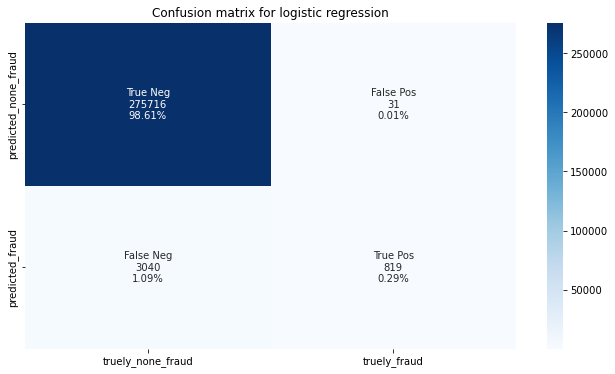

In [25]:
clf = LogisticRegression(random_state=0).fit(Xtr, ytr['isFraud'])
pred_log = clf.predict(X_test)

log_matrix = confusion_matrix(y_test, pred_log)

plot_confusion_matrix(log_matrix, 'logistic regression')
recall_score(y_test, pred_log)

##### Isolation Forest

In [26]:
ytr.mean()

isFraud    0.001552
dtype: float64

In [ ]:
# Hyper-parameter tuning, takes 539m 30.6s to run

clf = IsolationForest()

param_grid = {'n_estimators': list(range(100, 500, 50)), 
              'contamination': [0.001552, 'auto']} 


# f1sc = make_scorer(f1_score, average='micro')

grid_dt_estimator = model_selection.GridSearchCV(clf, 
                                                 param_grid,
                                                 scoring='f1_micro', 
                                                 refit=True,
                                                 cv=5, 
                                                 return_train_score=True)
grid_dt_estimator.fit(Xtr, ytr)


In [ ]:
grid_dt_estimator.best_estimator_

grid_dt_estimator.best_estimator_

Output:
    IsolationForest(contamination=0.001552, n_estimators=300)

In [27]:
iso_clf = IsolationForest(n_estimators = 300)
iso_clf.fit(Xtr, ytr)
iso_pred = iso_clf.predict(X_test)

Recall Score: 0.9209639803057788


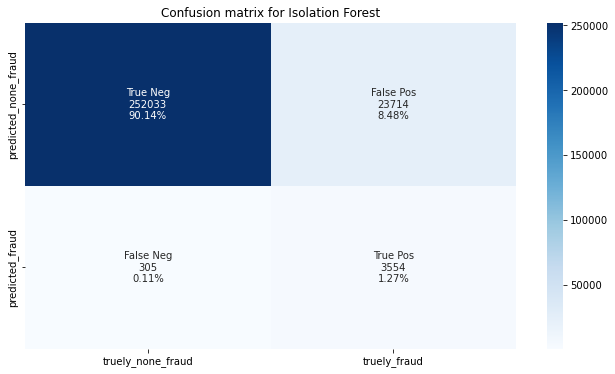

In [28]:
plot_confusion_matrix(confusion_matrix(y_test, iso_pred < 0), 'Isolation Forest')

print(f'Recall Score: {recall_score(y_test, iso_pred<0)}')

### Using Autoencoders for Anormally Detection

##### Model

In [36]:
class AutoEncoder(nn.Module):
    """
    This class defines the Autoencoder Model
    """

    def __init__(self, input_output_len, hidden_sizes):
        """
        This function initializes the autoencoder parameters

        Args:
            input_output_len: The length of the input features which in turn is same for the output features
            hidden_sizes: List of the sizes of the hidden nodes

        Return:
            None
        """

        super().__init__()
                                           
        self.layer1 = nn.Linear(input_output_len, hidden_sizes[0])
        self.layer2 =  nn.Linear(hidden_sizes[0], hidden_sizes[1])
        self.layer3 =  nn.Linear(hidden_sizes[1], hidden_sizes[2])
        self.layer4 = nn.Linear(hidden_sizes[2], hidden_sizes[3])

        self.linear = nn.Linear(hidden_sizes[3], input_output_len)

        self.droupout = nn.Dropout(0.3)

        for layers in [self.layer1, self.layer2, self.layer3, self.layer4]:
            nn.init.xavier_uniform_(layers.weight.data)
        
        torch.nn.init.xavier_uniform_(self.linear.weight.data)



    def forward(self, data):
        """
        Defines the forward pass of the Autoencoder

        Args:
            data: Dataset array
        
        Returns:
            Output Features
        """
        x = self.layer1(data)
        x = self.droupout(x)
        x = torch.tanh(x)
        x = self.layer2(x)
        x = self.droupout(x)
        x = torch.tanh(x)
        x = self.layer3(x)
        x = self.droupout(x)
        x = torch.tanh(x)
        x = self.layer4(x)
        x = self.droupout(x)
        x = torch.tanh(x)

        x = self.linear(x)

        return x


In [30]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [31]:
model = AutoEncoder(len(X_train.columns), hidden_sizes=[6, 4, 4, 6])
criterion = nn.MSELoss()
optimizer=torch.optim.Adam(model.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience = 3, factor = 0.5)
model = model.to(device)
print(model)

AutoEncoder(
  (layer1): Linear(in_features=9, out_features=6, bias=True)
  (layer2): Linear(in_features=6, out_features=4, bias=True)
  (layer3): Linear(in_features=4, out_features=4, bias=True)
  (layer4): Linear(in_features=4, out_features=6, bias=True)
  (linear): Linear(in_features=6, out_features=9, bias=True)
  (droupout): Dropout(p=0.3, inplace=False)
)


##### DataLoader

In [32]:
# Training train dataloader
train_data = torch.FloatTensor(X_train_train.values)
train_args = dict(shuffle = True, batch_size = 1024, num_workers=1)
train_loader = DataLoader( train_data, **train_args)

# Training validation dataloader
train_val_data = torch.FloatTensor(X_train_val.values)
train_val_args = dict(shuffle = False, batch_size = 1024, num_workers=1)
train_val_loader = DataLoader( train_val_data, **train_val_args)

##### Train and Validation functions

In [33]:
# Train the model

def train_model(train_loader, model):
    training_loss = 0
    
    # Set model in 'Training mode'
    model.train()
    
    # enumerate mini batches
    for i, inputs in enumerate(train_loader):
        inputs = inputs.to(device)

        # clear the gradients
        optimizer.zero_grad()
        
        
        # compute the model output
        out = model(inputs)
        
        # calculate loss
        loss = criterion(out, inputs)
        
        # Backward pass
        loss.backward()
        
        # Update model weights
        optimizer.step()

        training_loss += loss.item()
        
    training_loss /= len(train_loader)
    return training_loss

In [34]:
# Validate the model

def validate_model(train_val_loader, model):
    
    val_loss = 0
    
    # Set model in validation mode
    model.eval()
    
     # enumerate mini batches
    for i, inputs in enumerate(train_val_loader):
        inputs = inputs.to(device)

        # clear the gradients
        optimizer.zero_grad()
        
        
        # compute the model output
        out = model(inputs)
        
        # calculate loss
        loss = criterion(out, inputs)

        val_loss += loss.item()
        
    val_loss /= len(train_val_loader)
    return val_loss

##### Training the network

In [35]:
# Define number of epochs
epochs = 20
train_losses = [6000000]
val_losses = [6000000]

model = torch.load('model.pth') # model.pth was trained for 200 epochs until values where stagnant

for epoch in range(epochs):
    
    # Train
    training_loss = train_model(train_loader, model)

    # Validation
    val_loss = validate_model(train_val_loader, model)

    scheduler.step(val_loss)

    # Commented out since the model had been trained

    # if val_loss < val_losses[-1]:
    #     torch.save(model, 'model.pth')

    
    # Print log of accuracy and loss
    print("Epoch: "+str(epoch)+", Training loss: "+str(training_loss)+", Validation loss:"+str(val_loss))
    
    train_losses.append(training_loss)
    val_losses.append(val_loss)


Epoch: 0, Training loss: 0.004626805255413185, Validation loss:0.0027816092218391235
Epoch: 1, Training loss: 0.004634998798323903, Validation loss:0.0027816092218391235
Epoch: 2, Training loss: 0.0046363537712454835, Validation loss:0.0027816092218391235
Epoch: 3, Training loss: 0.00463914906883206, Validation loss:0.0027816092218391235
Epoch: 4, Training loss: 0.004642339409523473, Validation loss:0.0027816092218391235
Epoch: 5, Training loss: 0.004627802774413832, Validation loss:0.0027816092218391235
Epoch: 6, Training loss: 0.00463833371509545, Validation loss:0.0027816092218391235
Epoch: 7, Training loss: 0.004637707211995571, Validation loss:0.0027816092218391235
Epoch: 8, Training loss: 0.00463261857538067, Validation loss:0.0027816092218391235
Epoch: 9, Training loss: 0.0046388293874964305, Validation loss:0.0027816092218391235
Epoch: 10, Training loss: 0.004633908852715512, Validation loss:0.0027816092218391235
Epoch: 11, Training loss: 0.004642823124234186, Validation loss:0

#### Validating the model and setting threshold to classify fraudulent data

In [37]:
# Validation dataloader
val_data = torch.FloatTensor(X_val.values)
val_args = dict(shuffle = False, batch_size = 1, num_workers=1)
val_loader = DataLoader(val_data, **val_args)

# Test dataloader
test_data = torch.FloatTensor(X_test.values)
test_args = dict(shuffle = False, batch_size = 1, num_workers=1)
test_loader = DataLoader(test_data, **test_args)

In [38]:
# Test the model

def test_model(loader, model):
      
    model.eval()
    losses = []
    
     # enumerate mini batches
    for inputs in tqdm(loader):
        inputs = inputs.to(device)
           
        # compute the model output
        out = model(inputs)
        
        # calculate loss
        loss = criterion(out, inputs)

        losses += [loss.item()]
        
    return losses

In [39]:
reconstruction_loss = test_model(val_loader, model)
val_df = pd.DataFrame()
val_df['losses'] = reconstruction_loss
val_df['y'] = y_val.isFraud
val_df[val_df.y == 0].describe()

100%|██████████| 279605/279605 [05:47<00:00, 803.88it/s]


,losses,y
count,275747.000000,275747.0
mean,0.002765,0.0
std,0.005939,0.0
min,0.000002,0.0
25%,0.000039,0.0
50%,0.000179,0.0
75%,0.001226,0.0
max,0.227264,0.0


In [41]:
val_df[val_df.y == 1].describe()

,losses,y
count,3858.000000,3858.0
mean,0.022627,1.0
std,0.022172,0.0
min,0.000009,1.0
25%,0.007193,1.0
50%,0.017220,1.0
75%,0.034550,1.0
max,0.447041,1.0


##### Calculate the recall score with a threshold of 0.001

It is better to capture more of the fraudulent transaction, than not capture them, even if it means that some none-fraudulent data are classified as fraudulent but can be confirmed later with the customer

In [42]:
recall_score(y_val, val_df.losses > 0.001)

0.9626749611197511

#### Testing the Autoencoder model

In [43]:
reconstruction_loss_test = test_model(test_loader, model)

100%|██████████| 279606/279606 [05:45<00:00, 809.69it/s]


In [44]:
test_pred = np.array(reconstruction_loss_test) > 0.001

Recall Score: 0.9683855921223115


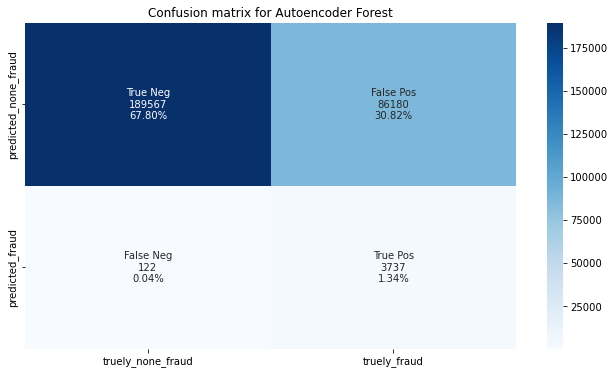

In [46]:
print(f'Recall Score: {recall_score(y_test, test_pred)}')
plot_confusion_matrix(confusion_matrix(y_test, test_pred), 'Autoencoder Forest')

### Preliminary to Deploying the model to Production Using Flask

In [57]:
dictionary = {
    "step":1,
    "type":"PAYMENT",
    "amount":9839.64,
    "nameOrig":"C1231006815",
    "oldbalanceOrig":170136.0,
    "newbalanceOrig":160296.36,
    "nameDest":"M1979787155",
    "oldbalanceDest":0.0,
    "newbalanceDest":0.0
    } 

      
# Serializing json  
json_object = json.dumps(dictionary) 
print(json_object)

{"step": 1, "type": "PAYMENT", "amount": 9839.64, "nameOrig": "C1231006815", "oldbalanceOrig": 170136.0, "newbalanceOrig": 160296.36, "nameDest": "M1979787155", "oldbalanceDest": 0.0, "newbalanceDest": 0.0}


In [64]:
type(json_object)

str

In [61]:
def test_model(loader, model):
      
    model.eval()
    losses = []
    
     # enumerate mini batches
    for inputs in loader:
        inputs = inputs.to(device)
           
        # compute the model output
        out = model(inputs)
        
        # calculate loss
        loss = criterion(out, inputs)

        losses += [loss.item()]
        
    return losses

In [68]:
res = ast.literal_eval(json_object)


,step,type,amount,nameOrig,oldbalanceOrig,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0


In [69]:
def get_prediction(json_object: str)-> json:

    """
    This function takes in a json file, performs predictions on it and returns a json prediction
    Args:
        file: json object containing input features

    Return:
        json object having predictions 
    """

    file = ast.literal_eval(json_object)

    data = pd.DataFrame(file, index=[0])

    prediction = {'isFraud': False}

    if (data.type == "CASH_OUT").bool() or (data.type == "TRANSFER").bool():
        target_encoding = joblib.load('target_encoding.gz')
        min_max_scaler = joblib.load('min_max_scaler.gz')
        saved_model = torch.load('model.pth')

        X = target_encoding.transform(data)
        X = min_max_scaler.transform(X)

        test_data = torch.FloatTensor(X)
        test_args = dict(shuffle = False, batch_size = 1, num_workers=1)
        test_loader = DataLoader(test_data, **test_args)

        reconstruction_loss_test = test_model(test_loader, saved_model)

        if np.array(reconstruction_loss_test) > 0.001:
            prediction['isFraud'] = True

    
    json_object = json.dumps(prediction)

    return json_object

In [70]:
get_prediction(json_object)

'{"isFraud": false}'